In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, chi2_contingency, zscore, shapiro, ttest_ind
pd.set_option('display.max_columns', None)
from statsmodels.stats.proportion import proportions_ztest



In [2]:
df_raw = pd.read_csv(r"/Users/muayadhilamia/Desktop/Ironhack/Week-5/Project/week5_6_project/data/cleaned/df_cleand_raw_m.csv")

                    --- Cleaning and sorting

In [ ]:
# making copy to avoid errors 
df = df_raw.copy()

# deleting "Unnamed" column 
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# dropping nulls in "Variation"
df = df[df['Variation'].notna() & (df['Variation'] != "")]

# columns i want them to be intger 
int_cols = [
    'client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 
    'clnt_age', 'num_accts', 'calls_6_mnth', 'logons_6_mnth',
    'num_steps', 'num_visits', 'total_steps', 'step_repeat_count', 'step_diff', "time_from_prev_step"
]
for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

# making "bal" float and round it 
if 'bal' in df.columns:
    df['bal'] = pd.to_numeric(df['bal'], errors='coerce').round(2)

# fixing date_time column 
if 'date_time' in df.columns:
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# dropping duplicates 
df = df.drop_duplicates()

# sorting by client, visit and date_time
df = df.sort_values(
    by=['client_id', 'visit_id', 'date_time'],
    ascending=[True, True, True]
)


                        --- Complete and Error rate and Hypothsis testing

In [20]:

# ---------- 1. KEEP LAST STEP PER VISIT ----------
df_last_visit = df.drop_duplicates(subset="visit_id", keep="last")

# ---------- 2. COMPLETION RATE ----------
completion_rate = df_last_visit.groupby('Variation')['completed'].mean()

# ---------- 3. ERROR RATE ----------
errors_per_visit = (
    df.groupby(['visit_id', 'Variation'])['error_flag']
    .sum()
    .reset_index(name='error_count')
)
errors_per_visit['has_error'] = errors_per_visit['error_count'] > 0
error_rate = errors_per_visit.groupby('Variation')['has_error'].mean()

# ---------- 4. PRINT KPI SUMMARY ----------
print("Completion Rate per group:\n", completion_rate)
print("\nError Rate per group:\n", error_rate)
print("*" * 50)

# ---------- 5. GROUP SPLITTING ----------
test_group_last = df_last_visit[df_last_visit['Variation'] == 'Test']
control_group_last = df_last_visit[df_last_visit['Variation'] == 'Control']

test_group_err = errors_per_visit[errors_per_visit['Variation'] == 'Test']
control_group_err = errors_per_visit[errors_per_visit['Variation'] == 'Control']

# ---------- 6. Z-TESTS FOR PROPORTIONS ----------
# Completion Rate
completion_counts = [
    test_group_last['completed'].sum(),
    control_group_last['completed'].sum()
]
completion_n = [
    len(test_group_last),
    len(control_group_last)
]
z_stat_comp, p_val_comp = proportions_ztest(
    count=completion_counts,
    nobs=completion_n,
    alternative='larger'  # one-sided: Test > Control
)

# Error Rate
error_counts = [
    test_group_err['has_error'].sum(),
    control_group_err['has_error'].sum()
]
error_n = [
    len(test_group_err),
    len(control_group_err)
]
z_stat_err, p_val_err = proportions_ztest(
    count=error_counts,
    nobs=error_n,
    alternative='smaller'  # one-sided: Test < Control
)

print("Completion Rate - Z-statistic:", round(z_stat_comp, 3))
print("Completion Rate - P-value:", round(p_val_comp, 4))

print("\nError Rate - Z-statistic:", round(z_stat_err, 3))
print("Error Rate - P-value:", round(p_val_err, 4))
print("*" * 50)

# ---------- 7. DECISION MAKING ----------
alpha = 0.05

# Completion Rate
if p_val_comp < alpha:
    print("\n✅ Test group has significantly higher completion rate than Control.")
else:
    print("\n❌ No statistical evidence that Test performed better in completion rate.")

# Error Rate
if p_val_err < alpha:
    print("✅ Test group has significantly lower error rate than Control.")
else:
    print("❌ No statistical evidence that Test had fewer errors than Control.")

Completion Rate per group:
 Variation
Control    0.498226
Test       0.584832
Name: completed, dtype: float64

Error Rate per group:
 Variation
Control    0.206126
Test       0.271192
Name: has_error, dtype: float64
**************************************************
Completion Rate - Z-statistic: 22.816
Completion Rate - P-value: 0.0

Error Rate - Z-statistic: 19.978
Error Rate - P-value: 1.0
**************************************************

✅ Test group has significantly higher completion rate than Control.
❌ No statistical evidence that Test had fewer errors than Control.


                    --- Step duration and hypothsis testing
                

In [ ]:
# ---------- Step 1: Compute step durations ----------
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
df = df.sort_values(by=['visit_id', 'process_step'])

# Calculate duration between steps (in seconds)
df['step_duration'] = (
    df.groupby('visit_id')['date_time']
    .diff()
    .dt.total_seconds()
)

# Remove first step (NaN duration)
df_steps = df.dropna(subset=['step_duration']).copy()

# ---------- Step 2: Remove outliers via IQR ----------
def remove_outliers_iqr(sub_df, col):
    """Remove outliers using IQR rule for one group."""
    Q1 = sub_df[col].quantile(0.25)
    Q3 = sub_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return sub_df[(sub_df[col] >= lower) & (sub_df[col] <= upper)]

# Apply outlier removal per Variation and process_step
groups = df_steps.groupby(['Variation', 'process_step'])
filtered_dfs = [remove_outliers_iqr(group, 'step_duration') for _, group in groups]
df_steps_no_outliers = pd.concat(filtered_dfs, ignore_index=True)

print(f"✅ Removed {len(df_steps) - len(df_steps_no_outliers)} outliers using IQR filtering.")

# ---------- Step 3: Average time per step ----------
avg_step_time = (
    df_steps_no_outliers
    .groupby(['Variation', 'process_step'])['step_duration']
    .mean()
    .reset_index()
    .round(2)
)

print("\n📊 Average step duration (seconds, after removing outliers):")
print(avg_step_time)

# ---------- Step 4: Hypothesis testing (one-sided t-test) ----------
results = []

for step in sorted(df_steps_no_outliers['process_step'].unique()):
    test_times = df_steps_no_outliers[
        (df_steps_no_outliers['Variation'] == 'Test') &
        (df_steps_no_outliers['process_step'] == step)
    ]['step_duration']

    control_times = df_steps_no_outliers[
        (df_steps_no_outliers['Variation'] == 'Control') &
        (df_steps_no_outliers['process_step'] == step)
    ]['step_duration']

    # One-tailed t-test: Test group expected to be faster (i.e., lower duration)
    t_stat, p_val = ttest_ind(test_times, control_times, alternative='less')

    results.append({
        'process_step': step,
        'test_mean': round(test_times.mean(), 2),
        'control_mean': round(control_times.mean(), 2),
        'mean_diff': round(control_times.mean() - test_times.mean(), 2),  # Positive = Test faster
        't_stat': round(t_stat, 3),
        'p_value': round(p_val, 4),
        'significant': p_val < 0.05
    })

results_df = pd.DataFrame(results)

print("\n📈 Step-wise t-test results (Test vs Control):")
print(results_df)

# ---------- Optional: Interpretation ----------
print("\n🔍 Interpretation of significant steps (Test significantly faster):")
sig_steps = results_df[results_df['significant'] == True]

if not sig_steps.empty:
    for _, row in sig_steps.iterrows():
        print(f"✅ Step {int(row['process_step'])}: Test group was significantly faster "
              f"by {row['mean_diff']} seconds (p = {row['p_value']})")
else:
    print("❌ No steps showed statistically significant improvement in the Test group.")

✅ Removed 47040 outliers using IQR filtering.

📊 Average step duration (seconds, after removing outliers):
  Variation  process_step  step_duration
0   Control             1         112.58
1   Control             2          28.03
2   Control             3          34.36
3   Control             4          72.06
4   Control             5          85.13
5      Test             1         121.43
6      Test             2          27.10
7      Test             3          33.56
8      Test             4          77.04
9      Test             5          69.54

📈 Step-wise t-test results (Test vs Control):
   process_step  test_mean  control_mean  mean_diff  t_stat  p_value  \
0             1     121.43        112.58      -8.85   6.380   1.0000   
1             2      27.10         28.03       0.93  -2.645   0.0041   
2             3      33.56         34.36       0.80  -2.553   0.0053   
3             4      77.04         72.06      -4.98   8.859   1.0000   
4             5      69.54         

In [21]:
df.shape

(317235, 26)

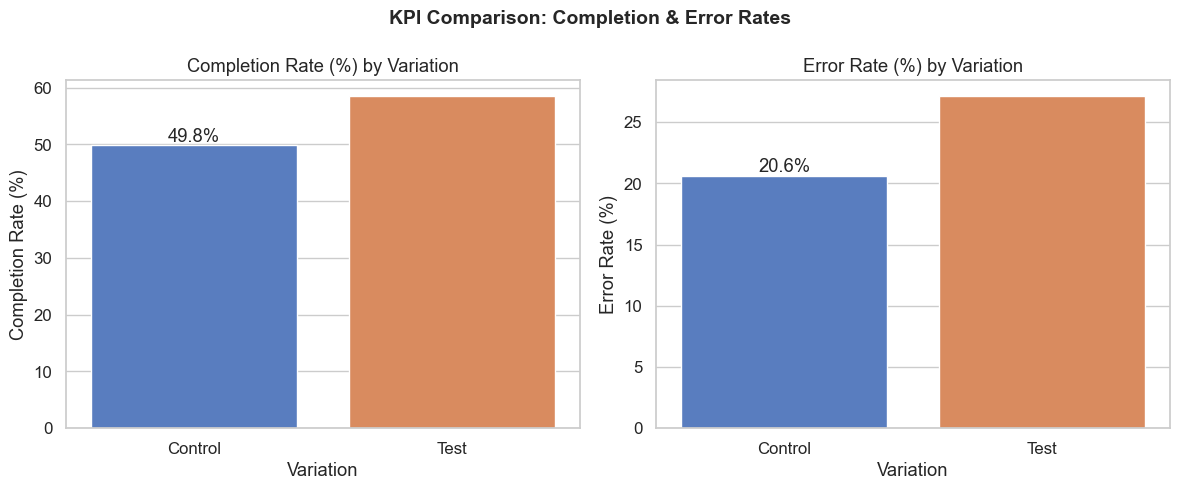

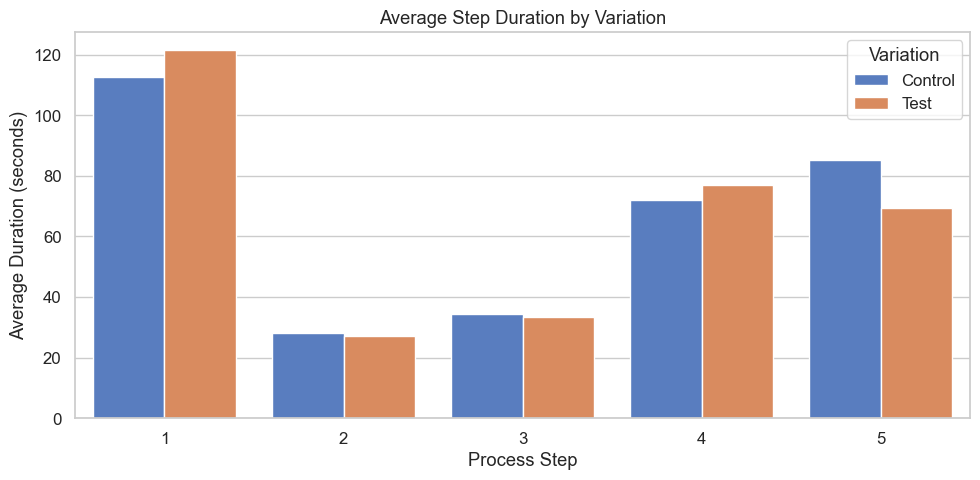

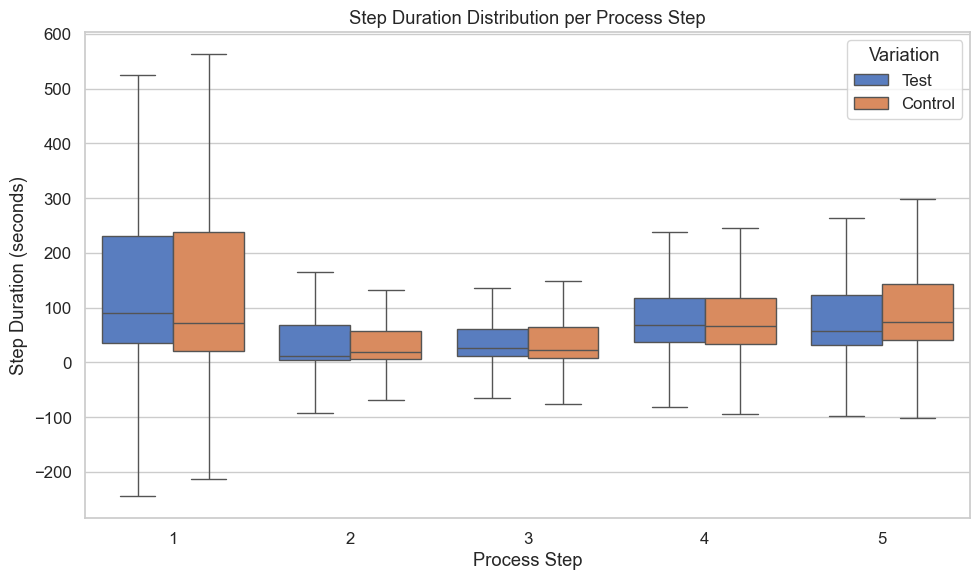

In [18]:

# ---------- SET GLOBAL STYLE ----------
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# ---------- 1️⃣ COMPLETION & ERROR RATE BAR CHART ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Completion Rate plot
sns.barplot(
    x=completion_rate.index,
    y=completion_rate.values * 100,
    ax=ax[0],
    hue=completion_rate.index,
    legend=False
)
ax[0].set_title("Completion Rate (%) by Variation")
ax[0].set_xlabel("Variation")
ax[0].set_ylabel("Completion Rate (%)")
ax[0].bar_label(ax[0].containers[0], fmt="%.1f%%")

# Error Rate plot
sns.barplot(
    x=error_rate.index,
    y=error_rate.values * 100,
    ax=ax[1],
    hue=error_rate.index,
    legend=False
)
ax[1].set_title("Error Rate (%) by Variation")
ax[1].set_xlabel("Variation")
ax[1].set_ylabel("Error Rate (%)")
ax[1].bar_label(ax[1].containers[0], fmt="%.1f%%")

plt.suptitle("KPI Comparison: Completion & Error Rates", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# ---------- 2️⃣ AVERAGE STEP DURATION BAR CHART ----------
# ---------- 2️⃣ AVERAGE STEP DURATION BAR CHART ----------
plt.figure(figsize=(10, 5))
sns.barplot(
    data=avg_step_time,
    x="process_step",
    y="step_duration",
    hue="Variation",
    errorbar=None  # replaces deprecated ci=None
)
plt.title("Average Step Duration by Variation")
plt.xlabel("Process Step")
plt.ylabel("Average Duration (seconds)")
plt.legend(title="Variation")
plt.tight_layout()
plt.show()

# ---------- 3️⃣ STEP DURATION DISTRIBUTION (BOXPLOT) ----------
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_steps,
    x="process_step",
    y="step_duration",
    hue="Variation",
    showfliers=False
)
plt.title("Step Duration Distribution per Process Step")
plt.xlabel("Process Step")
plt.ylabel("Step Duration (seconds)")
plt.legend(title="Variation")
plt.tight_layout()
plt.show()

In [22]:
df.shape

(317235, 26)

,client_id,visitor_id,visit_id,process_step,date_time,Variation,time_from_prev_step,time_from_start,num_steps,num_visits,last_step,completed,step_repeat_count,total_steps,step_diff,error_flag,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,age_group,step_duration
156680,3561384,451664975_1722933822,100012776_37918976071_457913,5,2017-04-26 13:22:17,Test,<NA>,0,2,2,5,True,2,1,<NA>,False,4,56,60,U,2,63130.44,6,9,55-64,NaN
156681,3561384,451664975_1722933822,100012776_37918976071_457913,5,2017-04-26 13:23:09,Test,52,52,2,2,5,True,2,1,0,False,4,56,60,U,2,63130.44,6,9,55-64,52.0
326754,7338123,612065484_94198474375,100019538_17884295066_43909,1,2017-04-09 16:20:56,Test,<NA>,0,11,3,5,True,3,5,<NA>,False,7,88,24,M,2,26436.73,6,9,18-24,NaN
326759,7338123,612065484_94198474375,100019538_17884295066_43909,1,2017-04-09 16:21:45,Test,4,49,11,3,5,True,3,5,-1,True,7,88,24,M,2,26436.73,6,9,18-24,49.0
326760,7338123,612065484_94198474375,100019538_17884295066_43909,1,2017-04-09 16:21:59,Test,14,63,11,3,5,True,3,5,0,False,7,88,24,M,2,26436.73,6,9,18-24,14.0


In [27]:
df['time_from_prev_step'].sum()

20639555

In [30]:
df_steps_no_outliers['step_duration'].sum()

12441008.0

In [31]:
df_steps_no_outliers.shape

(200990, 26)